# Executing a Rain over Africa retrieval

In this notebook I will walk you through finding, downloading, executing, and saving a Rain over Africa (RoA) retrieval.

My system is an eight-core CPU at 2.90 GHz, 64 GiB RAM, 6 GiB GPU, and over 800 Mbit/s download speed, running Ubuntu 22.04 server.

If you want to run an example yourself in a fre Google Colab GPU runtime, refer to [this other notebook](example_RoA_Colab.ipynb).

We require the Python packages listed in the cell below and to install the RoA package `roa`,
```
$ pip install git+https://github.com/SEE-GEO/roa
```

I show below the versions of my environment:

In [1]:
import datetime
from pathlib import Path
import shutil
import sys
import time

import cmocean
import eumdac
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import quantnn
import torch
import tqdm
import xarray as xr

# RoA library
from roa import (
    MSGNative,
    QUANTILES,
    prepare_dataset_for_network,
    Tiler
)
from roa.data import SEVIRI_0DEG_AREADEF

print(f"Python version {sys.version}\n")
for module in [eumdac, matplotlib, np, torch, xr]:
    print(f"{module.__name__}: {module.__version__}")

Python version 3.10.15 | packaged by conda-forge | (main, Oct 16 2024, 01:24:24) [GCC 13.3.0]

eumdac: 2.2.3
matplotlib: 3.9.2
numpy: 1.26.4
torch: 2.5.1+cu124
xarray: 2024.10.0


`roa` is at commit `9a8c5ab558dc8a977ea09d95922645c9bc9cc105`.

Let's say we want to run retrievals for the first day of 2023. Therefore, we define

In [2]:
dtstart = datetime.datetime(2023, 1, 1)
dtend = datetime.datetime(2023, 1, 2)

and use eumdac to search for the files

In [3]:
# Get access to EUMETSAT Data Store
with open('/home/amell/.eumdac/credentials') as handle:
    token = eumdac.AccessToken(handle.read().split(','))
datastore = eumdac.DataStore(token)
selected_collection = datastore.get_collection('EO:EUM:DAT:MSG:HRSEVIRI')

nat_files = [f for f in list(selected_collection.search(dtstart=dtstart, dtend=dtend))]

The variable `nat_files` contains all MSG observations at 0 degree for 2023-01-01, which we expect to be 96 (four per hour)

In [4]:
len(nat_files)

96

We will download file one file at a time and execute the retrieval on it. We will avoid downloading to disk, since we are not interested in keeping the input file.

In [5]:
# Load model
# CPU
model = torch.jit.load('../data/network_CPU.pt')
# GPU
model_gpu = torch.jit.load('../data/network_CPU.pt', map_location=torch.device('cuda'))

# For measuring time
times = {k: [] for k in ['download', 'preprocess', 'retrieval', 'retrieval_gpu', 'assembly', 'statistic', 'save']}

# Working path
# It's a tmpfs
opath = Path('/home/amell/tmp')

for p in tqdm.tqdm(nat_files):
    # ====================
    # Download
    t = time.time()
    entry = f'{str(p)}.nat'
    with p.open(entry=entry) as fsrc:
        with open(opath / entry, 'wb') as fdst:
            shutil.copyfileobj(fsrc, fdst)
    times['download'].append(time.time() - t)

    # ====================
    # Read data
    t = time.time()
    ds = MSGNative(opath / entry).get_dataset().load()
    ds = ds.assign_coords({"nat_file": entry}).expand_dims("nat_file")

    # Prepare the dataset for the network
    x = prepare_dataset_for_network(ds.sel(nat_file=entry))[None, ...]
    tiler = Tiler(x)
    
    # Get tiles and put them in the batch dimension
    x = torch.stack(
            [tiler.get_tile(i,j) for i in range(tiler.M) for j in range(tiler.N)],
            dim=0
        )
    x = x.view(-1, *x.shape[2:])
    times['preprocess'].append(time.time() - t)
    # ====================
    # Run inference
    # In CPU
    t = time.time()
    y_hat = torch.cat([model(x[:len(x) // 2]), model(x[len(x) // 2:])], dim=0)
    times['retrieval'].append(time.time() - t)
    # In GPU
    t = time.time()
    # Be kind to memory, do not store the output
    for i in range(len(x)):
        _ = model_gpu(x[[i]].cuda()).cpu()
    times['retrieval_gpu'].append(time.time() - t)
    # ====================
    # Assemble the tiles
    t = time.time()
    y_hat = y_hat.view(tiler.M, tiler.N, 1, *y_hat.shape[1:])
    y_hat = tiler.assemble(y_hat)
    times['assembly'].append(time.time() - t)
    # ====================
    # Compute statistics
    t = time.time()
    mu = quantnn.quantiles.posterior_mean(y_hat.numpy(), QUANTILES, quantile_axis=1)
    times['statistic'].append(time.time() - t)
    # ====================
    # Create an xarray.Dataset with the statistic computed
    t = time.time()
    ds_out = xr.Dataset(
        data_vars={
            "mu": (["nat_file", "y", "x"], mu)
        },
        coords={
            "x": ds.x.data,
            "y": ds.y.data,
            "nat_file": [entry]
        }
    )

    # and "save" it
    # Clear attributes that are not serializable
    for v in ds_out:
        ds_out[v].attrs = {}
    ds_out.to_netcdf(opath / f'{entry}.nc')
    times['save'].append(time.time() - t)
    # ====================
    # Cleanup before next iteration
    (opath / entry).unlink()
    (opath / f'{entry}.nc').unlink()

In [6]:
for k, v in times.items():
    v = np.array(v)
    print(f'{k}: {v.mean():.2f} +/- {v.std():.2f} [s]')

download: 101.13 +/- 60.12 [s]
preprocess: 4.53 +/- 0.59 [s]
retrieval: 246.35 +/- 1.75 [s]
retrieval_gpu: 22.99 +/- 0.47 [s]
assembly: 4.50 +/- 0.26 [s]
statistic: 2.98 +/- 0.17 [s]
save: 0.13 +/- 0.08 [s]


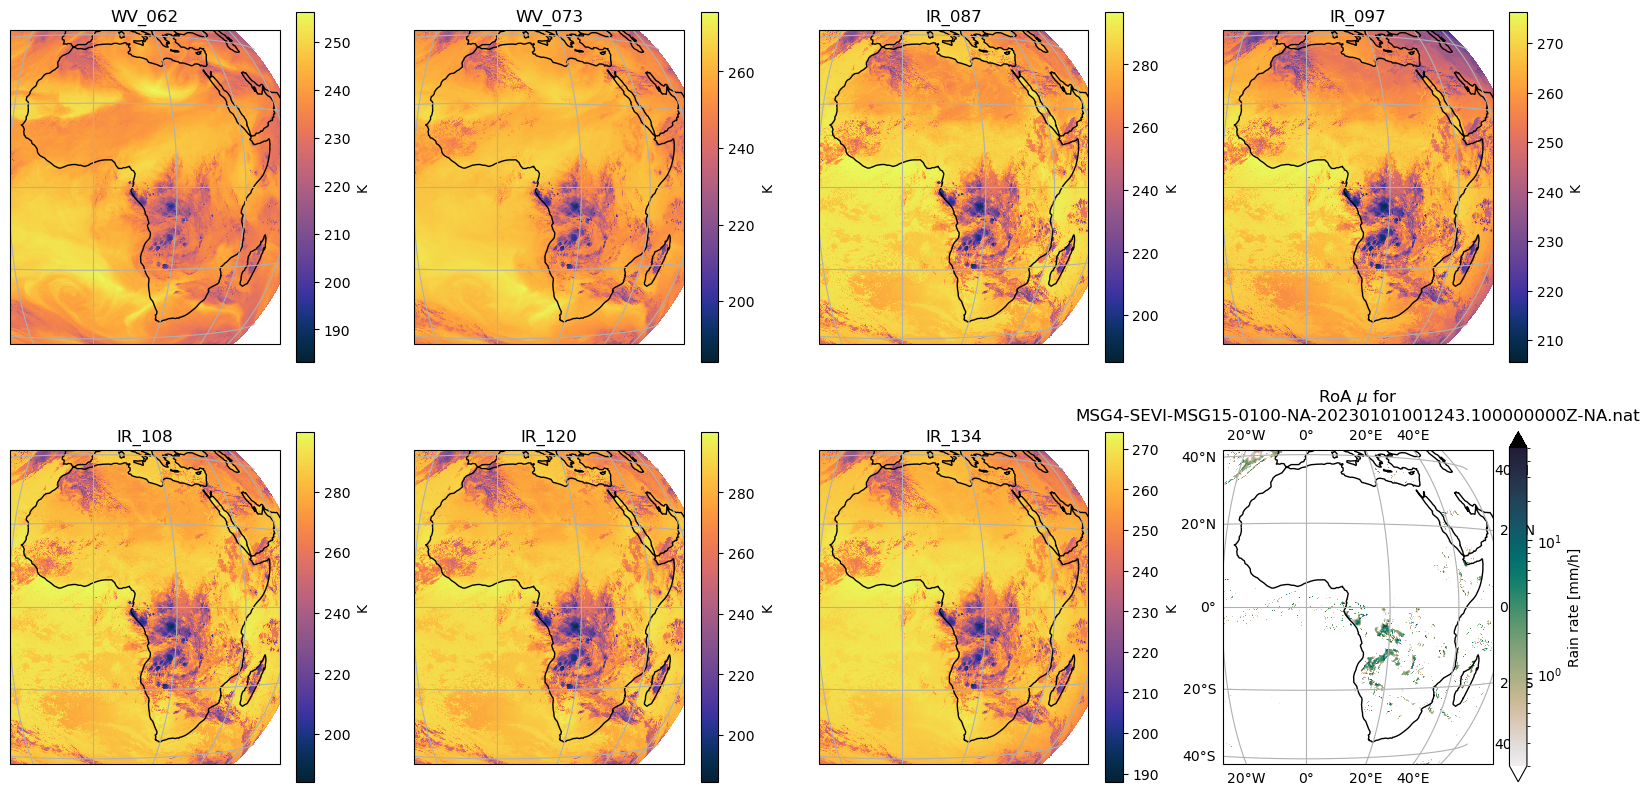

In [7]:
crs = SEVIRI_0DEG_AREADEF.to_cartopy_crs()
fig, axs = plt.subplots(ncols=4, nrows=2, subplot_kw={'projection': crs}, figsize=(20, 10))

for i, k in enumerate(list(ds)[:7]):
    ax = axs.ravel()[i]
    x, y = np.broadcast_arrays(ds.x.data[None, :], ds.y.data[:, None])
    m = ax.pcolormesh(x, y, ds[k].sel(nat_file=entry).data, transform=crs,
                      cmap=cmocean.cm.thermal)
    ax.coastlines()
    ax.gridlines()
    fig.colorbar(m, ax=ax, label=ds[k].units)
    ax.set_title(k)


ax = axs.ravel()[-1]
x, y = np.broadcast_arrays(ds_out.x.data[None, :], ds_out.y.data[:, None])
m = ax.pcolormesh(x, y, ds_out.mu.sel(nat_file=entry).data, transform=crs,
                  norm=matplotlib.colors.LogNorm(vmin=0.2, vmax=50),
                  cmap=cmocean.cm.rain)
m.cmap.set_under('white')
m.cmap.set_over('black')
ax.coastlines()
ax.gridlines(draw_labels=True)
fig.colorbar(m, ax=ax, label='Rain rate [mm/h]', extend='both')
ax.set_title(f'RoA $\mu$ for\n{ds_out.nat_file.data.item()}')
plt.show()